# Full clustering of the VNC with enrichment. 

The pairwise GMD was run on a hpc. This is code to perform the analysis. 

In [11]:
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.colors as mcolors
import pickle 
from collections import Counter
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
import math
from scipy.spatial.distance import squareform
import numpy as np
from pathlib import Path

import networkx as nx
from graspologic.match import graph_match
from sklearn import datasets, manifold
from matplotlib.pyplot import cm
import seaborn as sns
from adjustText import adjust_text
import pyarrow.parquet as pq

In [12]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
from module.utils import load_object, get_mapping_df

In [13]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance
from module.gramchd.nhood import get_io_top_NM, get_io_top_M
# from src.nhood_vis import df_to_graph
from module.gramchd.nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output
from module.utils import get_neighbourhood, get_w_threshold, entropy_calc
from module.enrichment_utils import *
from module.denclex.dendrogram_eval import get_clustering_stats, cluster_purity_test
from module.denclex.dendrograms_plotting import generate_cluster_evolution

In [14]:
datadate = '20231124'

In [ ]:
nb_name = '03_enriched_dendrogram'

cwd = Path.cwd()
save_things=False
if save_things:
    fig_dir = cwd.parent / 'figures' / nb_name
    fig_dir.mkdir(parents=True, exist_ok=True)

In [17]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})


vnc_meta.bodyId = vnc_meta.bodyId.astype('str')

In [18]:
heminames = ['07B', '11A', '11B', '02A', '18B', '12A', '01A', '10B', '06A', \
             '06B', '19A', '21A', '03B', '23B', '12B', '13B', '05B', '20A.22A', \
             '08A', '09A']
# n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))&(vnc_meta['birthtime']=='secondary')].bodyId.values)) # the integers have the numpy.int64 datatype!

n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted(n_ids)

In [19]:
len(n_ids)

8591

In [20]:
node_number = 50
th=0

# graphs = load_object(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_M{node_number}_th{th}_combined.pkl')


nexist_ids = list(vnc_meta.bodyId.sort_values())



In [21]:
##### Collect relevant batches together to save as one:

# filenames = []
# for i in [0,1,2,3,4,5]:
    # filenames.append(f'../../data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_full_{i}_combined.parquet')
# to_concat = []
# for filename in filenames:
#     parquet_file = pq.ParquetFile(filename)
#     sliced_list = []
#     for i in parquet_file.iter_batches(use_threads=True):
#         # print("RecordBatch")
#         _df = i.to_pandas()
#         sliced =_df[_df['id_1'].isin(n_ids)&_df['id_2'].isin(n_ids)]

#         if len(sliced)>0:
#             # print(sliced)
#             sliced_list.append(sliced)
#     to_concat.append(pd.concat(sliced_list))
#     # break

# 2m 29s

# output = pd.concat(to_concat).drop_duplicates()
# output = output.sort_values(['id_1', 'id_2']).reset_index(drop=True)
# output.to_parquet(f'../../data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice.parquet')

In [22]:
output = pd.read_parquet(f'../../data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice.parquet')

secondary_neurons_only = output[output.id_1.isin(n_ids)&output.id_2.isin(n_ids)]

# Weight stats


In [23]:
# partner_dfs = []
int_n_ids = [int(i) for i in n_ids]

# normed_partner_cum_sum_dfs = []
# partner_cum_sum_dfs = []

# for i in int_n_ids:
#     # print(i)
#     partner_df = get_io_top_M(Id=i, df=get_w_threshold(vnc_edges, thrshld=0), M=None).reset_index(drop=True)
#     partner_cum_sum_df = partner_df.iloc[:,1:].cumsum(axis='index')
#     total_weights = partner_df.iloc[:, 1:].sum(axis=0).to_dict()
#     normed_partner_cum_sum_df = partner_cum_sum_df.div(total_weights) # normalised by total
#     partner_dfs.append(partner_df)
#     partner_cum_sum_dfs.append(partner_cum_sum_df)
#     normed_partner_cum_sum_dfs.append(normed_partner_cum_sum_df)


In [24]:
# vnc_meta_idind = vnc_meta.set_index('bodyId')

# M = 50

# partner_info = {}
# for i in int_n_ids:
#     # print(i)
#     partner_df = get_io_top_M(Id=i, df=get_w_threshold(vnc_edges, thrshld=0), M=M).reset_index(drop=True)
#     # partner_cum_sum_df = partner_df.iloc[:,1:].cumsum(axis='index')
#     partner_ids = partner_df.id.astype(str).tolist()
#     partner_id_type_dict = vnc_meta_idind.loc[partner_ids].type.to_dict()
#     partner_info[i] = partner_id_type_dict

In [25]:
# node_overlap_data =[]
# node_type_overlap_data = []

# for i in range(len(n_ids)):
#     id_1 = n_ids[i]
#     info_1 = partner_info[int(id_1)]
#     ids_1 = set(info_1.keys())

#     for j in range(i+1, len(n_ids)):
#         id_2 = n_ids[j]
#         info_2 = partner_info[int(id_2)]
#         ids_2 = set(info_2.keys())

#         types_1 = Counter(info_1.values())
#         types_2 = Counter(info_2.values())

#         node_overlap = len(ids_1 & ids_2)/ len(ids_1 | ids_2)
#         node_type_overlap = sum((types_1 & types_2).values())/ sum((types_1 | types_2).values())
#         node_overlap_data.append(node_overlap)
#         node_type_overlap_data.append(node_type_overlap)

# output['node_overlap']=node_overlap_data
# output['ntype_overlap']=node_type_overlap_data

# save the node overlap data:
# output.to_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice_overlap_secn.parquet')


In [26]:
# # output.to_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice_overlap.parquet')
output = pd.read_parquet(f'../../data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice_overlap.parquet')


In [27]:
# # output = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_M50_hemisample_slice_overlap_secn.parquet')


# trials = output[['id_1', 'id_2']].to_numpy()

# node_overlap_data =[]
# node_type_overlap_data = []
# for pair in trials:
#     id_1, id_2 = pair
#     # print(id_1, id_2)
#     info_1 = partner_info[int(id_1)]
#     info_2 = partner_info[int(id_2)]

#     ids_1 = set(info_1.keys())
#     ids_2 = set(info_2.keys())

#     types_1 = Counter(info_1.values())
#     types_2 = Counter(info_2.values())

#     node_overlap = len(ids_1 & ids_2)/ len(ids_1 | ids_2)
#     node_type_overlap = sum((types_1 & types_2).values())/ sum((types_1 | types_2).values())
#     node_overlap_data.append(node_overlap)
#     node_type_overlap_data.append(node_type_overlap)
#     # nhood_overlap_data.append({'id_1':id_1, 'id_2':id_2, 'node_overlap':node_overlap, 'ntype_overlap':node_type_overlap})

#     # print(len(ids_1 & ids_2)/ len(ids_1 | ids_2))
#     # print(sum((types_1 & types_2).values())/ sum((types_1 | types_2).values()))

#     # print('\n\n')

# nM_stats = {}

# for M in [50]:
#     M_id_dict = {}
#     for ind, val in enumerate(int_n_ids):
#         #     print(ind, val, M)
#             _df = normed_partner_cum_sum_dfs[ind]
#             ith_check = min(len(_df)-1, M-1)
#             M_id_dict[val] = normed_partner_cum_sum_dfs[ind].loc[ith_check].to_dict()
#     n_ids_M_cumweight_df = pd.DataFrame.from_dict(M_id_dict, orient='index')
#     n_ids_M_cumweight_df.index = n_ids_M_cumweight_df.index.astype(str)

#     nM_stats[M] = n_ids_M_cumweight_df



# with open('./data/vnc/hemi/nM_stats_funchemi.pkl', 'wb') as f:
#     pickle.dump(nM_stats, f)

In [28]:

with open('../../data/vnc/hemi/nM_stats_funchemi.pkl', 'rb') as f:
    nM_stats = pickle.load(f)



In [29]:
colors = [(0, 'red'), (0.5, 'white'), (1, 'green')]

# Create a colormap
wcmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors)

# Clustering:

In [30]:
n_ids_meta = vnc_meta[vnc_meta['bodyId'].isin(n_ids)].copy(True).set_index('bodyId')


In [31]:
n_ids_meta.birthtime.value_counts(dropna=False)

birthtime
secondary          6359
early secondary    1294
primary             938
Name: count, dtype: int64

In [32]:
hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))

func_hemi_map = {'posture':['03B', '23B', '12B', '13B', '05B', '20A.22A', '08A', '09A'], \
                 'uc_leg_movement':['06A', '06B', '19A', '21A', '23B'], \
                 'walking':['18B', '12A', '01A', '10B'],\
                 'wing_wave':['12A', '03B'],
                 'wing_buzz':['07B', '11A', '11B', '02A', '18B', '12A'], \
                 'takeoff': ['07B', '11A', '11B', '18B'] }


# numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
# for i, category in enumerate(hemi_uniques):
#     numeric_hemi_data[hemi_ind == category] = i

colors = cm.tab10.colors[:len(hemi_uniques)]


# func_hemi_map = {'posture':['3B', '23B', '12B', '13B', '5B', '20A', '22A', '8A', '9A'], \
#                  'uc_leg_movement':['6A', '6B', '19A', '21A', '23B'], \
#                  'walking':['18B', '12A', '1A', '10B'],\
#                  'wing_wave':['12A', '3B'],\
#                  'wing_buzz':['7B', '11A', '11B', '2A', '18B', '12A'], \
#                  'takeoff': ['7B', '11A', '11B', '18B'] }
func_colors = cm.Dark2.colors[:len(func_hemi_map)]

func_colors_list = [matplotlib.colors.ListedColormap(('white', i)) for i in func_colors]


func_colors_map = dict(zip(func_hemi_map.keys(), func_colors_list))


func_hemi_numeric_colours = {}
for func_label, categories in func_hemi_map.items():
    numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
    # for i, category in enumerate(hemi_uniques):
    hemi_bool = [True if i in categories else False for i in hemi_ind ]
    numeric_hemi_data[hemi_bool] = 1
    func_hemi_numeric_colours[func_label]= numeric_hemi_data


In [33]:
hemi_numeric_separate_cols = {}

for hemi_label in heminames:
    numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
    # for i, category in enumerate(hemi_uniques):
    hemi_bool = hemi_ind == hemi_label
    numeric_hemi_data[hemi_bool] = 1
    hemi_numeric_separate_cols[hemi_label]= numeric_hemi_data

hemi_colors_list = [matplotlib.colors.ListedColormap(('white', 'black')) for i in heminames]
hemi_colors_map = dict(zip(heminames, hemi_colors_list))

## horizontal

In [34]:
M=50
dist_df = output

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= len(func_hemi_map) + 1


In [35]:

# # Create a colormap from the colors
# # hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# # Plot the categorical data
# # method = 'ward'


# fig = plt.figure(figsize=(25, 10))
# # fig.suptitle(f'{M} neighbours', fontsize=16)

# gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
#                                    height_ratios=[3,6], hspace=0.05)
# gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
#                                                   height_ratios=[1,0],
#                                                   hspace=0)

# ax_col_dendrogram = fig.add_subplot(gs1[0])

# col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
# ax_col_dendrogram.set_axis_off()

# xind = col_dendrogram['leaves']

# xmin,xmax = ax_col_dendrogram.get_xlim()
# N_type_data= len(hemi_numeric_separate_cols) 

# gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

# n_ids_cumweight_df = nM_stats[M]
# # type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 
# # type_data=zip([numeric_hemi_data],[hemicmap], ['hemilineage']) 


# type_data=zip([hemi_numeric_separate_cols[key] for key in heminames],[hemi_colors_map[key] for key in heminames], heminames) 
# # type_data=zip([func_hemi_numeric_colours[key] for key in func_hemi_map.keys()] + [n_ids_cumweight_df.total_weight.to_numpy()],\
# #               [func_colors_map[key] for key in func_hemi_map.keys()] + [wcmap], \
# #                 list(func_hemi_map.keys()) + ['total_weight']) 


# for i,(data,cmap, label) in enumerate(type_data):
#     ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
#     ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
#     ax.set_yticks([])
#     ax.set_ylabel(label, rotation=0, ha='right', va='center')
#     ax.set_xticks([])
#     plt.setp(ax.get_xticklabels(), visible=False)


# if save_things:
#     plt.savefig(f'../figures/{nb_name}/weg_func_hemisample_M{M}_topview_2.pdf', bbox_inches='tight', dpi=300, transparent=True)
#     plt.savefig(f'../figures/{nb_name}/weg_func_hemisample_M{M}_topview_2.png', bbox_inches='tight', dpi=300, transparent=True)



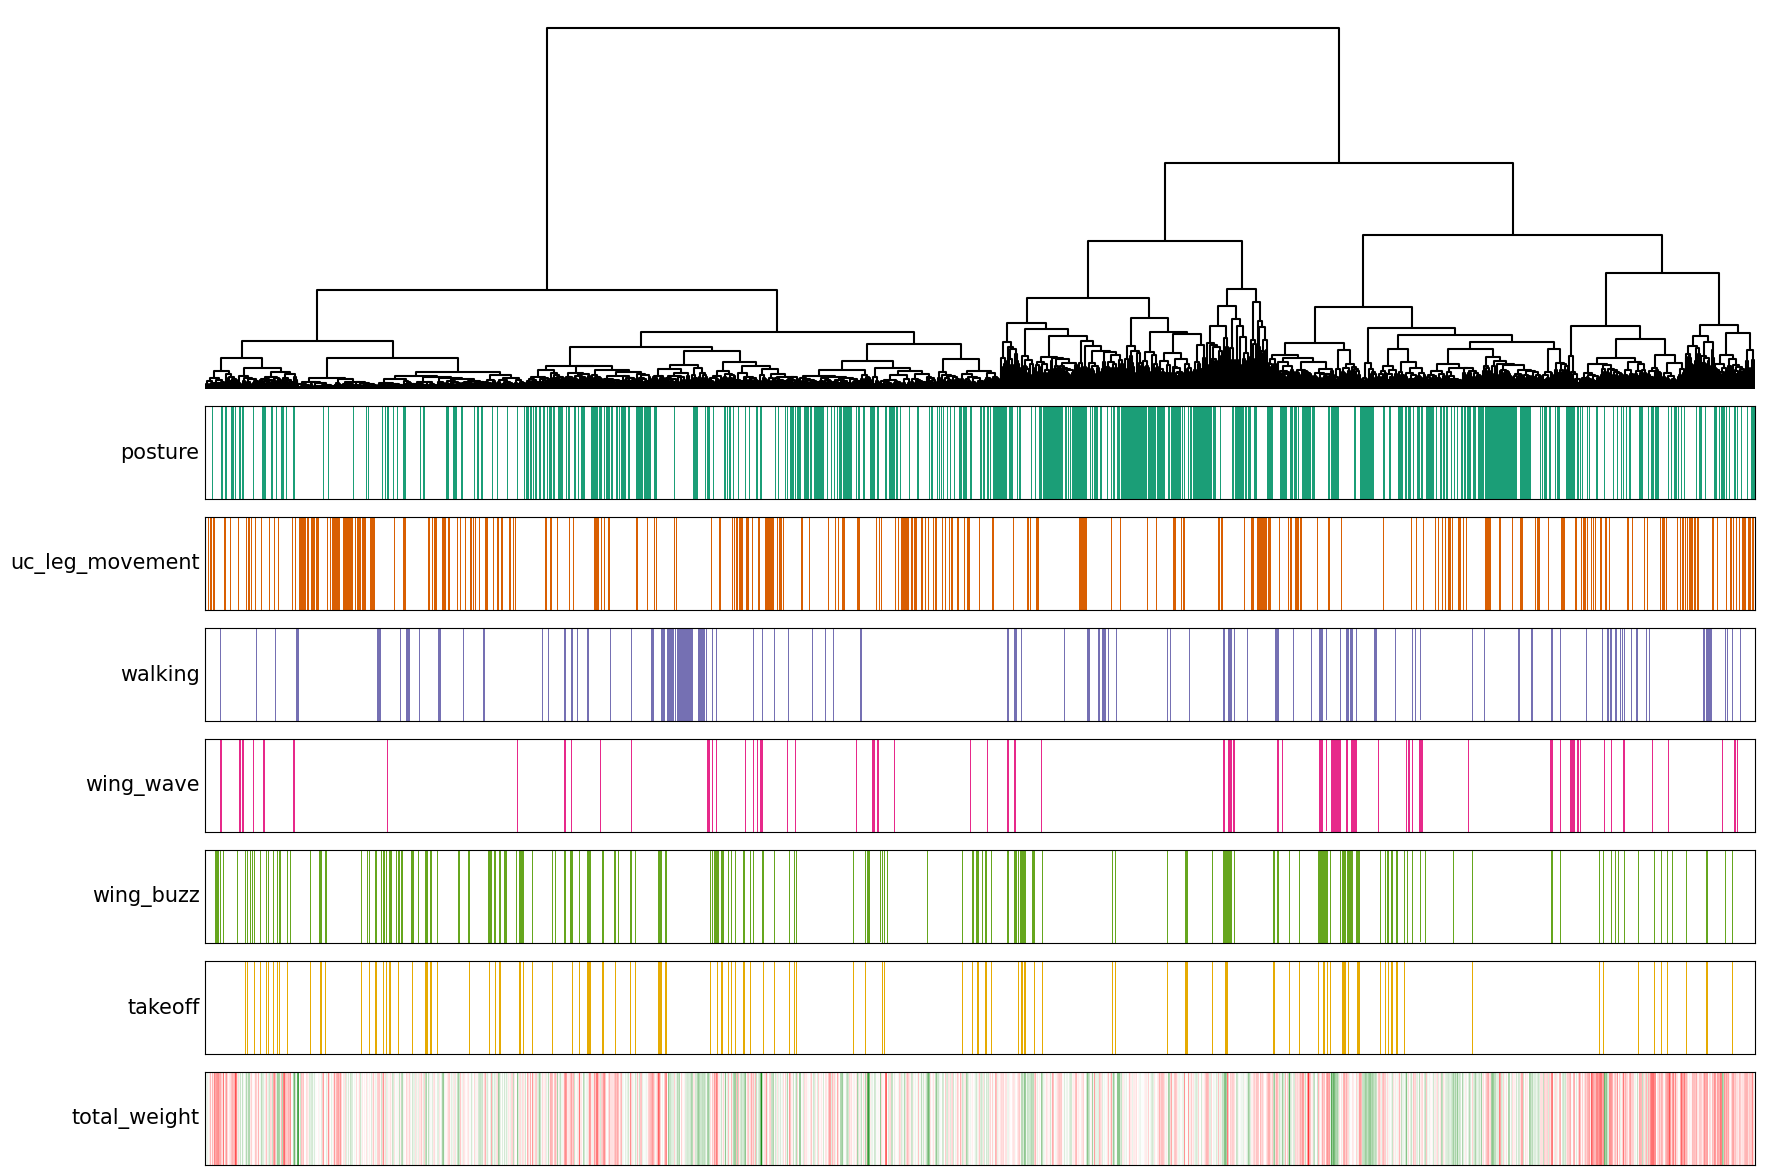

In [36]:

# Create a colormap from the colors
# hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(20, 15))
# fig.suptitle(f'{M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[3,6], hspace=0.03)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
# type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 
# type_data=zip([numeric_hemi_data],[hemicmap], ['hemilineage']) 


# type_data=zip([func_hemi_numeric_colours[key] for key in func_hemi_map.keys()],[func_colors_map[key] for key in func_hemi_map.keys()], func_hemi_map.keys()) 
type_data=zip([func_hemi_numeric_colours[key] for key in func_hemi_map.keys()] + [n_ids_cumweight_df.total_weight.to_numpy()],\
              [func_colors_map[key] for key in func_hemi_map.keys()] + [wcmap], \
                list(func_hemi_map.keys()) + ['total_weight']) 


for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center', size=15)
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)

# save_things=False
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_func_hemisample_M{M}_topview_2.pdf', bbox_inches='tight', dpi=300, transparent=True)
    plt.savefig(f'../figures/{nb_name}/weg_func_hemisample_M{M}_topview_2.png', bbox_inches='tight', dpi=300, transparent=True)

# save=False

# statistics:

## hemilineage 

In [36]:
hemitype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage').bodyId.apply(list).to_dict()

In [37]:
len(hemitype_to_leaf)

20

In [ ]:
# label = list(hemitype_to_leaf.keys())[2]
# ids_to_inspect = hemitype_to_leaf[label]
# print(label)
# cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

# largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
# # lps.append(largest_pure) 

# n_singletons = sum([len(i)==1 for i in cl_purity])
# n_non_singletons = len(cl_purity) - n_singletons
# n_non_singletons_members = len(ids_to_inspect) - n_singletons
# print('number of singletons', n_singletons)
# print('number non-singleton clusters', n_non_singletons)
# print('number of neurons in non-singleton clusters', n_non_singletons_members)

03B
number of singletons 96
number non-singleton clusters 102
number of neurons in non-singleton clusters 391


In [ ]:
# hemi_pure_cluster_dict = {}

# for label in heminames:
#     print(label)
#     ids_to_inspect = hemitype_to_leaf[label]
#     cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

#     #non single clusters, sorted
#     clusters = sorted([i for i in cl_purity if len(i)>1], key=lambda x: -len(x))

#     # largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
#     # lps.append(largest_pure) 

#     # n_singletons = sum([len(i)==1 for i in cl_purity])
#     # n_non_singletons = len(cl_purity) - n_singletons
#     # n_non_singletons_members = len(ids_to_inspect) - n_singletons
#     # print('number of singletons', n_singletons)
#     # print('number non-singleton clusters', n_non_singletons)
#     # print('number of neurons in non-singleton clusters', n_non_singletons_members)

#     hemi_pure_cluster_dict[label] = {'clusters':clusters}


##### Save: 
# with open(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hemi_pure_cluster_dict.pkl', 'wb') as f:
#     pickle.dump(hemi_pure_cluster_dict, f)


In [40]:
with open(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hemi_pure_cluster_dict.pkl', 'rb') as f:
    hemi_pure_cluster_dict = pickle.load(f)




In [ ]:
# stat_dict = {}

# for label in heminames:
#     ids_to_inspect = hemitype_to_leaf[label]
#     cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

#     largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
#     # lps.append(largest_pure) 

#     n_singletons = sum([len(i)==1 for i in cl_purity])
#     n_non_singletons = len(cl_purity) - n_singletons
#     n_non_singletons_members = len(ids_to_inspect) - n_singletons
#     print('number of singletons', n_singletons)
#     print('number non-singleton clusters', n_non_singletons)
#     print('number of neurons in non-singleton clusters', n_non_singletons_members)

#     stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons}
# # number of singletons n_s
# # number of members in nonsingleton pure clusters m_p
# # number of non singleton pure clusters n_p
# # 20 mins


# stat_df = pd.DataFrame.from_dict(stat_dict, orient='index')

In [41]:
stat_df = pd.read_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hemi_pure_cluster_stats.parquet')

In [42]:
stat_df['av_size'] = stat_df['m_p']/stat_df['n_p']
stat_df['coverage'] = stat_df['m_p']/(stat_df['n_s'] + stat_df['m_p'])


In [43]:
stat_df.sort_values('coverage').sort_values('coverage')

,n_s,m_p,n_p,av_size,coverage
21A,138,250,80,3.125000,0.644330
18B,66,122,52,2.346154,0.648936
19A,194,377,120,3.141667,0.660245
12B,178,371,112,3.312500,0.675774
02A,99,209,80,2.612500,0.678571
11A,59,132,41,3.219512,0.691099
05B,94,233,84,2.773810,0.712538
06B,123,324,106,3.056604,0.724832
11B,45,129,37,3.486486,0.741379
01A,102,311,91,3.417582,0.753027


In [44]:
stat_df.m_p.sum()

6571

In [45]:
stat_df.m_p.sum() /(stat_df.m_p.sum() + stat_df.n_s.sum() )

0.7648702130136189

In [55]:
# stat_df.to_parquet(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hemi_pure_cluster_stats.parquet')

## functional hemilineage groups

In [40]:
func_hemi_to_leaf = {funcname: n_ids_meta[n_ids_meta['hemilineage'].isin(func_hemi_map[funcname])].index.tolist() for funcname in func_hemi_map.keys()}

In [57]:
# label = list(func_hemi_to_leaf.keys())[0]
# ids_to_inspect = func_hemi_to_leaf[label]
# print(label)
# cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

# largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
# # lps.append(largest_pure) 

# n_singletons = sum([len(i)==1 for i in cl_purity])
# n_non_singletons = len(cl_purity) - n_singletons
# n_non_singletons_members = len(ids_to_inspect) - n_singletons
# print('number of singletons', n_singletons)
# print('number non-singleton clusters', n_non_singletons)
# print('number of neurons in non-singleton clusters', n_non_singletons_members)

In [58]:
# n_singletons

In [59]:
# n_non_singletons

In [60]:
# func_stat_dict = {}
# func_stat_dict['posture'] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}

In [61]:
# func_stat_dict

In [62]:

# for label in list(func_hemi_map.keys())[1:]:
#     print(label)
#     ids_to_inspect = func_hemi_to_leaf[label]
#     cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)
#     largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
#     n_singletons = sum([len(i)==1 for i in cl_purity])
#     n_non_singletons = len(cl_purity) - n_singletons
#     n_non_singletons_members = len(ids_to_inspect) - n_singletons
#     print('number of singletons', n_singletons)
#     print('number non-singleton clusters', n_non_singletons)
#     print('number of neurons in non-singleton clusters', n_non_singletons_members)
#     print('largest pure', largest_pure)

#     func_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}
# # 23 mins

In [63]:
# func_stat_df = pd.DataFrame.from_dict(func_stat_dict, orient='index')

In [64]:
# func_stat_df['av_size'] = func_stat_df['m_p']/func_stat_df['n_p']
# func_stat_df['coverage'] = func_stat_df['m_p']/(func_stat_df['n_s'] + func_stat_df['m_p'])


In [47]:
func_stat_df = pd.read_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/funchemi_pure_cluster_stats.parquet')

In [48]:
func_stat_df['av_size'] = func_stat_df['m_p']/func_stat_df['n_p']
func_stat_df['coverage'] = func_stat_df['m_p']/(func_stat_df['n_s'] + func_stat_df['m_p'])


In [49]:
func_stat_df['lps'] * (func_stat_df['n_s'] + func_stat_df['m_p'])

posture            41.0
uc_leg_movement    33.0
walking            33.0
wing_wave          17.0
wing_buzz          39.0
takeoff            16.0
dtype: float64

In [50]:
func_stat_df.sort_values('coverage')

,n_s,m_p,n_p,lps,av_size,coverage
takeoff,279,904,294,0.013525,3.074830,0.764159
walking,267,1095,272,0.024229,4.025735,0.803965
wing_buzz,353,1457,436,0.021547,3.341743,0.804972
uc_leg_movement,475,1973,561,0.013480,3.516934,0.805964
wing_wave,136,670,168,0.021092,3.988095,0.831266
posture,556,3361,727,0.010467,4.623109,0.858055


In [51]:
func_stat_df.m_p.sum() /(func_stat_df.m_p.sum() + func_stat_df.n_s.sum() )

0.8207530799930591

In [52]:
func_stat_df.m_p.sum()

9460

In [53]:
# func_stat_df.to_parquet(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/funchemi_pure_cluster_stats.parquet')

# Node/ node type overlap 

In [56]:
non_ntypezero = output[output['ntype_overlap']!=0.]

non_nzero =  output[output['node_overlap']!=0.]

In [58]:
nzero_non_ntypezero = output[(output['ntype_overlap']!=0.)&(output['node_overlap']==0.)] # no common nodes, but has common node types


### See if the graph matching produces corresponding node types within pairwise neighbourhoods that have high cell type overlap

In [ ]:
# def get_mapping_df(structure_1, structure_2, colnames, full_inds):
#     '''Params:
#     two dfs of ordered structure, 
#     the full indices for which structure 2 must be indexed, 
#     colnames for which the first and second element indexes the respective dfs, 

#     return the df mapping the node matching with structure 1 order as the base. 
#     '''

#     structure_1_copy = structure_1.reset_index().rename(columns={'index':colnames[0]}).copy(True)
#     structure_2_copy = structure_2.iloc[full_inds].reset_index().rename(columns={'index':colnames[1]}).copy(True)

#     g2_to_g1_node_mapping = pd.concat([structure_1_copy, structure_2_copy], axis=1)
#     g2_to_g1_node_mapping.replace({'':np.nan}, inplace=True)
#     g2_to_g1_node_mapping.dropna(how='all', inplace=True)
#     return g2_to_g1_node_mapping

In [61]:
hi_ntype_overlap = nzero_non_ntypezero[nzero_non_ntypezero['ntype_overlap']>0.32].sort_values('ntype_overlap', ascending=False)

In [62]:
trials = hi_ntype_overlap[['id_1', 'id_2']].to_numpy()

In [63]:
trials_ids = list(int(i) for i in set(trials.flatten()))

In [64]:
len(trials_ids)

2167

In [65]:
# n_ids_meta = vnc_meta[vnc_meta['bodyId'].isin([str(i) for i in trials_ids])].copy(True).set_index('bodyId')
n_ids_ptn = get_neighbourhood(Ids=trials_ids, df=vnc_edges)
pp_set = set(n_ids_ptn[['pre', 'post']].to_numpy().flatten())
n_ids_nhood = vnc_edges[vnc_edges['post'].isin(pp_set) & vnc_edges['pre'].isin(pp_set)].sort_index().copy(True)


In [ ]:
# M=50
# # hemi_graphs = prepare_nhood_graphs(all_ids=ctype_ids, df=n_ids_nhood, edge_number=None, node_number=M, directed=True)
# hemi_graphs = prepare_nhood_graphs(all_ids=trials_ids, df=n_ids_nhood, edge_number=None, node_number=M, directed=True)

# # 9 minutes

# with open(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hi_ntype_overlap_graphs.pickle', 'wb') as handle:
#     pickle.dump(hemi_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:

with open(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/hi_ntype_overlap_graphs.pickle', 'rb') as handle:
    hi_ntype_overlap_graphs = pickle.load(handle)

In [ ]:
# output=[]
# for trial in trials: 
#     id_A = int(trial[0])
#     id_B = int(trial[1])

#     m_output = []
#     # for i in range(len(n_ids)):
#         # id_A = n_ids[i]
#     id_A_ew_adj_mat = hemi_graphs[id_A]['ew_adj_mat']
#     id_A_ew_nnames = hemi_graphs[id_A]['ew_g_nnames']

#         # for j in range(i+1, len(n_ids)):
#             # id_B = n_ids[j]
#     id_B_ew_adj_mat = hemi_graphs[id_B]['ew_adj_mat']
#     id_B_ew_nnames = hemi_graphs[id_B]['ew_g_nnames']


#     gs = {id_A:id_A_ew_adj_mat, id_B:id_B_ew_adj_mat}
            
#     srtd = sorted([(gs[k], k) for k in [id_A, id_B]], key=lambda x:x[0].shape[1])
#     # adj_1 = srtd[0][0] # smaller graph
#     # adj_2 = srtd[1][0] # larger graph
#     id_1 = srtd[0][1]
#     id_2 = srtd[1][1]

#     id_1_ew_nnames = hemi_graphs[id_1]['ew_g_nnames']
#     id_2_ew_nnames = hemi_graphs[id_2]['ew_g_nnames']

#     one_index = np.arange(len(id_1_ew_nnames))[id_1 == np.array(id_1_ew_nnames)][0]
#     two_index = np.arange(len(id_2_ew_nnames))[id_2 == np.array(id_2_ew_nnames)][0]
#     pmatch = np.array([[one_index, two_index]])  # partial match seeding.

#     perm_inds, id_1, id_2 = perform_matching(id_A=id_1, id_B=id_2, graphs=gs, match_args={'rng':0, 'padding':'naive', 'transport':True, 'partial_match':pmatch, 'n_init':1})
#     # print(perm_inds)

#     # all_inds = list(range(hemi_graphs[id_2]['ew_adj_mat'].shape[1]))
#     # not_matched = [int(i) for i in all_inds if i not in perm_inds]
#     # full_inds = np.concatenate([perm_inds, not_matched])

#     wadj_1 = hemi_graphs[id_1]['ew_adj_mat']# smaller weighted adj mat
#     wadj_2 = hemi_graphs[id_2]['ew_adj_mat']# larger weighted adj mat

#     all_inds = list(range(wadj_2.shape[1]))
#     not_matched = [int(i) for i in all_inds if i not in perm_inds]
#     full_inds = np.concatenate([perm_inds, not_matched])


#     calc = matching_distance(id_1=id_A, id_2=id_B, adj_1=wadj_1, adj_2=wadj_2, perm_inds=perm_inds, directed=True)
#     # calc.update({'id_1': id_A, 'id_2':id_B})
#     m_output.append(calc)

#     id_1_ew_nnames_ego_removed = np.array([str(i) for i in id_1_ew_nnames])[list(range(one_index)) + list(range(one_index+1,len(id_1_ew_nnames)))]
#     id_2_ew_nnames_ego_removed = np.array([str(i) for i in id_2_ew_nnames])[list(range(two_index)) + list(range(two_index+1,len(id_2_ew_nnames)))]

#     two_index_removed_full_inds = full_inds[~(full_inds==two_index)]
#     full_inds_ego_removed = two_index_removed_full_inds - (two_index_removed_full_inds > two_index)
#     order_1 = pd.DataFrame({'id_1':(id_1_ew_nnames_ego_removed)})
#     order_2 = pd.DataFrame({'id_2':(id_2_ew_nnames_ego_removed)})
#     mapping = get_mapping_df(structure_1=order_1, structure_2=order_2, colnames=['id_1_index', 'id_2_index'], full_inds=full_inds_ego_removed)[['id_1', 'id_2']]

#     cols = ['bodyId', 'type', 'instance']
#     col_names = ['id_1'] + [f'{col}_id_1' for col in cols[1:]] + ['id_2'] + [f'{col}_id_2' for col in cols[1:]]
#     ctype_mapping = mapping.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()[col_names]
#     joint_counter = Counter(ctype_mapping['type_id_2']) & Counter(ctype_mapping['type_id_1'])
#     nhood_ntype_match_score = str(sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2'])) + '/' + str(sum(joint_counter.values()))
#     numeric_match_score = sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2'])/sum(joint_counter.values())
#     ntype_overlap_val = sum(joint_counter.values())
#     calc.update({'ntype_overlap':ntype_overlap_val, 'numeric_match_score':numeric_match_score,\
#                  'nhood_ntype_match_score':nhood_ntype_match_score})
#     output.append(calc)
#     # nhood_ntype_match_score
#     # print(sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2']), 'matched out of', 
#     #   sum(joint_counter.values()), 
#     #   'possible matching'
#     #   )
# nhood_ntype_match_df = pd.DataFrame.from_dict(output)

In [67]:
nhood_ntype_match_df  = pd.read_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_hi_ntype_overlap_stats.parquet')

In [69]:
nhood_ntype_match_df.id_1 = nhood_ntype_match_df.id_1.astype(str)
nhood_ntype_match_df.id_2 = nhood_ntype_match_df.id_2.astype(str)

cols = ['bodyId','class', 'hemilineage']
nhood_ntype_match_df = nhood_ntype_match_df.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()


In [70]:
nhood_ntype_match_df['class_match'] = nhood_ntype_match_df['class_id_1'] == nhood_ntype_match_df['class_id_2']
nhood_ntype_match_df['hemilineage_match'] = nhood_ntype_match_df['hemilineage_id_1'] == nhood_ntype_match_df['hemilineage_id_2']

In [71]:
print('out of', len(nhood_ntype_match_df))
print(len(nhood_ntype_match_df.query('class_match==False')), 'pair(s) did not match cell classes')
print(len(nhood_ntype_match_df.query('hemilineage_match==False')), 'pair(s) did not match hemilineages')


out of 2708
2 pair(s) did not match cell classes
1 pair(s) did not match hemilineages


We're looking at neurons that have no neuron correspondence, but high neuron cell type correspondence. 

Most of the high node type overlap (compared to the union of neighbours) candidates are themselves copies of the same cell type. 
- Interesting cases are when the same cell type have low number of nhood_ntype_match_score as well... this means that the cell types have a specific/different connectivity role in different parts of the brain... 

Additionally: there are high ntype_overlap cases whose central nodes (egos) are not a cell type match. This means that they share a lot of neighbours, even though they are not the same cell type... Very similar cell types, even more so if they have a strong match of neighbourhood match scores. 

In [ ]:
# nhood_ntype_match_df.to_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_hi_ntype_overlap_stats.parquet')

# hi_ntype_overlap_stats for ntype_overlap >25, or 0.33. 

### pvalues for matching:

In [122]:
# match_pval_stats = []
# for idx in range(len(nhood_ntype_match_df)):
#     pair = nhood_ntype_match_df.iloc[idx][['id_1', 'id_2']].values
#     matching_stat = nhood_ntype_match_df.iloc[idx]['nhood_ntype_match_score'].split('/')
#     ego_match = nhood_ntype_match_df.iloc[idx]['ego_match']
#     matching_n = int(matching_stat[0])
#     matching_potential = int(matching_stat[1])
#     id_1 = int(pair[0])
#     id_2 = int(pair[1])
#     id_1_ew_nnames = hemi_graphs[id_1]['ew_g_nnames']
#     id_2_ew_nnames = hemi_graphs[id_2]['ew_g_nnames']
#     one_index = np.arange(len(id_1_ew_nnames))[id_1 == np.array(id_1_ew_nnames)][0]
#     two_index = np.arange(len(id_2_ew_nnames))[id_2 == np.array(id_2_ew_nnames)][0]
#     pmatch = np.array([[one_index, two_index]])  # partial match seeding.
#     id_1_ew_nnames_ego_removed = np.array(id_1_ew_nnames)[list(range(one_index)) + list(range(one_index+1,len(id_1_ew_nnames)))]
#     id_2_ew_nnames_ego_removed = np.array(id_2_ew_nnames)[list(range(two_index)) + list(range(two_index+1,len(id_2_ew_nnames)))]
#     id_1_ew_ntypes = vnc_meta[vnc_meta.bodyId.isin([str(i) for i in id_1_ew_nnames_ego_removed])]['type'].values
#     id_2_ew_ntypes = vnc_meta[vnc_meta.bodyId.isin([str(i) for i in id_2_ew_nnames_ego_removed])]['type'].values
#     type_id_2_coutner = Counter(id_2_ew_ntypes)
#     type_id_1_coutner = Counter(id_1_ew_ntypes)
    
#     joint_counter = type_id_2_coutner & type_id_1_coutner
#     joint_ctype_n = len(joint_counter)
#     all_ctypes = set(id_1_ew_ntypes)| set(id_2_ew_ntypes)
#     name_dict = dict(zip(all_ctypes , range(len(all_ctypes))))
#     ele_one = np.array([name_dict.get(ele) for ele in id_1_ew_ntypes])
#     ele_two = np.array([name_dict.get(ele) for ele in id_2_ew_ntypes])

#     trial_n = 100000
#     result = []
#     np.random.seed(idx)

#     for _ in range(trial_n):
#         # np.random.shuffle(one)
#         np.random.shuffle(ele_two)
#         b = sum(ele_one == ele_two)
#         result.append(b)
#     result = np.array(result, dtype=np.int32) 
#     outcomes = []
#     for i in range(len(ele_one)):
#         num_outcomes = sum(result == i)
#         outcomes.append(num_outcomes)
#     rand_probabilities = np.array(outcomes)/trial_n

#     offset = 0
#     while True:
#         est_pval = sum(rand_probabilities[matching_n - offset:])
#         if est_pval>(1/trial_n):
#             break
#         offset += 1
#     pval_n = matching_n - offset
#     average_matched = np.mean(result)
#     std_matched = np.std(result)
#     # print(rand_probabilities)
#     # print(est_pval)
#     # print(matching_n)
#     # print(pval_n)

#     output_dict = {'id_1': str(id_1), 'id_2': str(id_2),'joint_ctype_n':joint_ctype_n, 'matching_n': matching_n, 'ntype_overlap': matching_potential, 
#                    'est_pval':est_pval, 'pval_n':pval_n, 'average_matched':average_matched, 'std_matched': std_matched, 'ego_match':ego_match}
#     match_pval_stats.append(output_dict)

# match_pval_stats_df = pd.DataFrame.from_dict(match_pval_stats)
# match_pval_stats_df.to_parquet(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/match_pval_stats.parquet')
# sampling with 10^5 iterations takes 72 minutes. 

In [72]:
match_pval_stats = pd.read_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/match_pval_stats.parquet')

match_pval_stats['numeric_match_score'] = match_pval_stats['matching_n'] /match_pval_stats['ntype_overlap'] 
match_pval_stats['null_numeric_match_score'] = match_pval_stats['average_matched'] /match_pval_stats['ntype_overlap'] 

In [74]:
siglevel = 0.0001

# Cluster enrichment

### perform for all functional hemilineages:

In [42]:
func_hemi_to_leaf = {funcname: n_ids_meta[n_ids_meta['hemilineage'].isin(func_hemi_map[funcname])].index.tolist() for funcname in func_hemi_map.keys()}

In [43]:
func_heminames = list(func_hemi_to_leaf.keys())
func_hemi_size_dict = {key:len(val) for key, val in func_hemi_to_leaf.items()}

In [44]:
rel_df = get_clustersize_range(Z=Z, ind_to_id=ind_to_id, sizes=[2, 30])

rel_df['n'] = rel_df.cluster.apply(len)

In [45]:
cluster_list = rel_df.cluster.tolist()

In [48]:
alpha = 0.1

pvals_dfs=[]
enriched_types = []
for cluster_to_test in cluster_list[:]:

    func_hemi_count = np.array([[neuron in func_hemi_to_leaf.get(func_label, []) for func_label in func_heminames]  for neuron in cluster_to_test])
    cluster_funccount = dict(zip(func_heminames, func_hemi_count.sum(axis=0)))
    n = len(cluster_to_test)
    N = len(n_ids)
    m = len(cluster_funccount)
    result = []
    for func_label, count in cluster_funccount.items(): 
        k = count
        K = func_hemi_size_dict.get(func_label) 
        # print(k, n, K, N)
        pval = one_test(k=k, n=n, K=K, N=N) 
        result.append({'name':func_label, 'k':k, 'K':K, 'p_vals':pval})
    pvals_df = pd.DataFrame(result).sort_values('p_vals', ascending=True).reset_index(drop=True)
    pvals_df['BH_adjusted'] = ((pvals_df.index + 1) * alpha)/m 
    pvals_df['Reject H_0'] = pvals_df['p_vals']<= pvals_df['BH_adjusted'] 
    max_ind = max([ind if val == True else -1 for ind, val in pvals_df['Reject H_0'].to_dict().items()])
    pvals_df.loc[:max_ind, 'Reject H_0'] = True
    pvals_dfs.append(pvals_df)
    enriched_types.append(pvals_df[pvals_df['Reject H_0']==True].name.values)

    # sns.scatterplot(pvals_df, x=pvals_df.index, y='p_vals')

    # sns.scatterplot(x=pvals_df[pvals_df['Reject H_0']==True].index, y=pvals_df[pvals_df['Reject H_0']==True].p_vals, color='orange')
    # plt.xlabel('index')
    # plt.title(f'cluster: {cluster_to_test}, size = {n}')

    # plt.plot(list(range(m)), np.array(range(m))*alpha/m, 'red')
    # plt.show()

# 2-1000 length clusters - 1min 48

In [49]:
lowest_pval_list = []
for pvals_df in pvals_dfs:
    rejected_pvals = pvals_df[pvals_df['Reject H_0'] == True]['p_vals'].values
    if len(rejected_pvals)>0:
        lowest_pval = rejected_pvals[0]
    else: 
        lowest_pval = 'None'
    lowest_pval_list.append(lowest_pval)

### Enrichment cluster analysis 

In [50]:
enriched_lens = [len(i) for i in enriched_types]

In [51]:
rel_df['e_num'] = enriched_lens
rel_df['enriched'] = enriched_types
rel_df['lowest_pval'] = lowest_pval_list

In [52]:
clusterids = []
rel_df.sort_values(['e_num', 'n'], ascending=[False, False]).reset_index(drop=False).query('index.isin([7523, 7829])')

,index,cluster,dists,n,e_num,enriched,lowest_pval
955,7829,"(18640, 21303, 14465, 155524, 18823, 19969, 18...",1686.818911,24,1,[uc_leg_movement],0.002105
4070,7523,"(10864, 10975, 10859, 11715)",1374.528283,4,0,[],None


In [53]:
# sort by number of enriched terms (largest first) and if they have the same, then larger cluster should be prioritised.
cluster_df = rel_df.sort_values(['e_num', 'n'], ascending=[False, False]).reset_index(drop=False) 
# cluster_df = rel_df.query('n<13').sort_values(['e_num', 'n'], ascending=[False, False]).reset_index(drop=False) 

total = set()
save = []
for i in range(len(cluster_df)):
    clstr = cluster_df.iloc[i].cluster
    if len(total & set(clstr)) == 0:
        save.append(i)
        total |= set(clstr)

print(len(save))

cluster_df = cluster_df.iloc[save]

939


In [134]:
# these are clusters that have focused enrichment:
# cluster_df[cluster_df['e_num']==1].sort_values('n').to_csv('./data/data_1.csv')

In [54]:
big_cluster = cluster_df[cluster_df['e_num']>1].sort_values('n', ascending=False).cluster.iloc[0]

In [55]:
np.set_printoptions(precision=2)


In [56]:
big_cluster = cluster_df[cluster_df['e_num']>1].sort_values('n', ascending=False).cluster.iloc[32]
cluster_labels = np.array([[1 if i in ids else 0 for ids in func_hemi_to_leaf.values() ] for i in big_cluster])
cluster_prop_vectors = cluster_labels / cluster_labels.sum(axis=1)[:,None]
average_cluster_prop_vector = cluster_prop_vectors.sum(axis=0)/cluster_prop_vectors.shape[0]
average_entropy = np.mean([entropy_calc(i) for i in cluster_prop_vectors], dtype=np.float64)
entropy_of_av_vector = entropy_calc(average_cluster_prop_vector)
delta_S = entropy_of_av_vector - average_entropy 
print(cluster_labels)
print(cluster_prop_vectors)
print(np.array([["{:.2f}".format(abs(entropy_calc(i))) for i in cluster_prop_vectors]]).T)
print(average_cluster_prop_vector)
print("{:.3f}".format(average_entropy))
print("{:.3f}".format(entropy_of_av_vector))
print("{:.3f}".format(delta_S))

[[0 1 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]]
[[0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]]
[['0.00']
 ['0.69']
 ['0.69']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.00']
 ['0.0

In [ ]:
enriched_clusters = cluster_df[cluster_df['e_num']>0].sort_values('n', ascending=False).copy(True)
cluster_labels = np.array([[1 if i in ids else 0 for func_label, ids in func_hemi_to_leaf.items() ] for i in big_cluster])
cluster_prop_vectors = cluster_labels / cluster_labels.sum(axis=1)[:,None]

In [60]:
delta_Ss = []
big_clusters = cluster_df[cluster_df['e_num']>0].sort_values('n', ascending=False).cluster.values[:]
for big_cluster in big_clusters:

    cluster_labels = np.array([[1 if i in ids else 0 for ids in func_hemi_to_leaf.values() ] for i in big_cluster])
    cluster_prop_vectors = cluster_labels / cluster_labels.sum(axis=1)[:,None]
    average_cluster_prop_vector = cluster_prop_vectors.sum(axis=0)/cluster_prop_vectors.shape[0]
    average_entropy = np.mean([entropy_calc(i) for i in cluster_prop_vectors], dtype=np.float64)
    entropy_of_av_vector = entropy_calc(average_cluster_prop_vector)
    delta_S = entropy_of_av_vector - average_entropy 
    delta_Ss.append(delta_S)


In [61]:
enriched_clusters['delta_S'] = delta_Ss

In [63]:
# enriched_clusters.to_parquet(f'./data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_enriched_clusters_u30.parquet')
# enriched clusters form a set of [2, 30] and filtered by e_num (largest first) and n (largest first)

In [65]:
# col_sum = cluster_prop_vectors.sum(axis=0)
# row_sum = cluster_prop_vectors.sum(axis=1)
# rtot = 0
# for i in range(cluster_prop_vectors.shape[0]):
#     for j in range(cluster_prop_vectors.shape[1]):
#         if cluster_prop_vectors[i,j] == 0:
#             continue
#         cc_entropy = (cluster_prop_vectors[i,j]) * np.log(cluster_prop_vectors[i,j]/(col_sum[j]))
#         rtot+=cc_entropy

# print(((rtot)/cluster_labels.shape[0])  +np.log(cluster_labels.shape[0]))